该笔记本实现**步骤4-6**

## Imports

In [2]:
import pandas as pd
import numpy as np

# 去除切片复制警告
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set(font_scale = 2)

# 输入缺失值和缩放值
from sklearn.preprocessing import Imputer, MinMaxScaler

# 机器学习模型
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# 超参调试
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 

## Read in Data

In [3]:
# 将数据读取到dataframes
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# 显示数据大小
print('训练特征数据集大小：', train_features.shape)
print('测试特征数据集大小：', test_features.shape)
print('训练标签数据集大小：', train_labels.shape)
print('测试标签数据集大小：', test_labels.shape)

训练特征数据集大小： (6622, 64)
测试特征数据集大小： (2839, 64)
训练标签数据集大小： (6622, 1)
测试标签数据集大小： (2839, 1)


In [4]:
train_features.head(10)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,4.80,40.725136,-74.004438,2.0,37.0,5.516649,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,67.14,40.637833,-73.973045,12.0,490.0,5.426271,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4280,2670505,113150.0,1938,1,100,78.4,5.7,NaN,30.73,40.776035,-73.964418,8.0,142.0,6.067036,3.425239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12974,2964670,137

In [5]:
train_labels.head(10)

,score
0,16.0
1,53.0
2,99.0
3,35.0
4,91.0
5,94.0
6,92.0
7,50.0
8,78.0
9,48.0


Text(0.5,1,'Energy Star Score Distribution')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


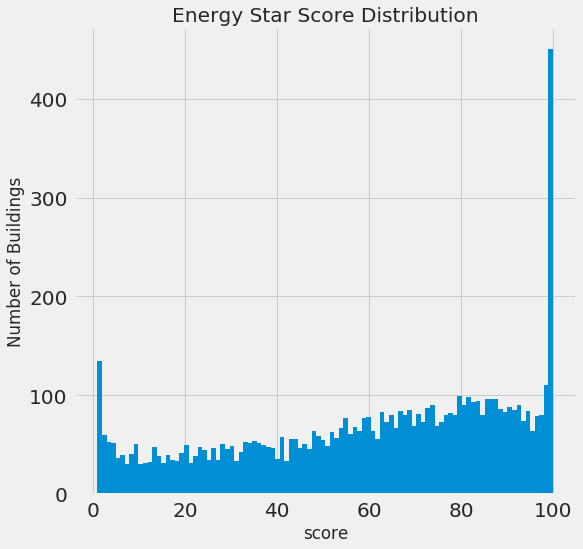

In [27]:
# 分数分布
figsize(8, 8)
# 正常显示中文
#plt.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins=100)
plt.xlabel('score')
plt.ylabel('Number of Buildings')
#plt.title('能源之星分数分布')
plt.title('Energy Star Score Distribution')

# Evaluating and Comparing Machine Learning Models
*  mean absolute error
*  average of 25 points（baseline）

## Imputing Missing Values
**缺失值插补**：列的**中位数**填充缺失值

为了避免**数据泄漏**（来自测试集的信息“泄漏”到训练过程中），测试集中的缺失值用训练集中相应列的中值填充。

In [7]:
# 创建imputer用以中值填充
imputer = Imputer(strategy='median')

# 在训练特征集上训练
imputer.fit(train_features)

# 转换训练集和测试集
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

print('训练特征集上的缺失值：', np.sum(np.isnan(X)))
print('测试特征集上的缺失值：', np.sum(np.isnan(X_test)))

训练特征集上的缺失值： 0
测试特征集上的缺失值： 0


In [8]:
# 确保所有值都是有限的
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


## Scaling Features
**特征缩放**：每个特征具有不同的单位，对特征进行标准化，以使单位不影响算法。

线性回归和随机森林不需要特征缩放，但其他方法（例如支持向量机和k最近邻）需要特征缩放，因为它们考虑了观测之间的欧几里德距离。因此，在比较多个算法时，最佳做法是特征缩放。

**特征缩放**方法：
* 每个值减去特征的平均值并**除以**特征的标准偏差。这称为**标准化**，特征分布均值为0和标准差为1。
* 每个值减去特征的最小值并**除以**特征的最大值减去最小值（范围）。确保特征的所有值都在0到1之间，并称为**缩放到范围或标准化**。

In [9]:
# 创建0-1的缩放目标
scaler = MinMaxScaler(feature_range=(0, 1))

# 在训练集训练
scaler.fit(X)

# 转换训练集和测试集
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [10]:
# 将y转换成一维数组（向量）
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

## Models to Evaluate
五种机器学习模型：
* 线性回归（LR）
* 支持向量机回归（SVMR）
* 随机森林回归（RFR）
* 梯度提升回归（GBR）
* k最近邻回归(KNNR)

**比较模型**，使用Scikit-Learn模型超参数的**默认值**。首先，确定每个模型的基线性能，然后选择性能最佳的模型，以便使用超参数调整进行进一步优化。

In [11]:
# MAE
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

def fit_and_evaluate(model):
    # 训练模型
    model.fit(X, y)
    # 预测和评估
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    return model_mae

In [12]:
# 线性回归（LR）
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)
print('线性回归在测试集上性能：MAE = %0.4f' % lr_mae)

线性回归在测试集上性能：MAE = 13.4651


In [13]:
# 支持向量机回归（SVMR）
svm = SVR(C=1000, gamma=0.1)
svm_mae = fit_and_evaluate(svm)
print('支持向量机回归在测试集上性能：MAE = %0.4f' % svm_mae)

支持向量机回归在测试集上性能：MAE = 10.9337


In [14]:
# 随机森林回归（RFR）
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)
print('随机森林回归在测试集上性能：MAE = %0.4f' % random_forest_mae)

随机森林回归在测试集上性能：MAE = 10.0147


In [15]:
# 梯度提升回归（GBR）
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)
print('梯度提升回归在测试集上性能：MAE = %0.4f' % gradient_boosted_mae)

梯度提升回归在测试集上性能：MAE = 10.0132


In [16]:
# k最近邻回归(KNNR)
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)
print('k最近邻回归在测试集上性能：MAE = %0.4f' % knn_mae)

k最近邻回归在测试集上性能：MAE = 13.0131


Text(0.5,1,'Model Comparison on Test MAE')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


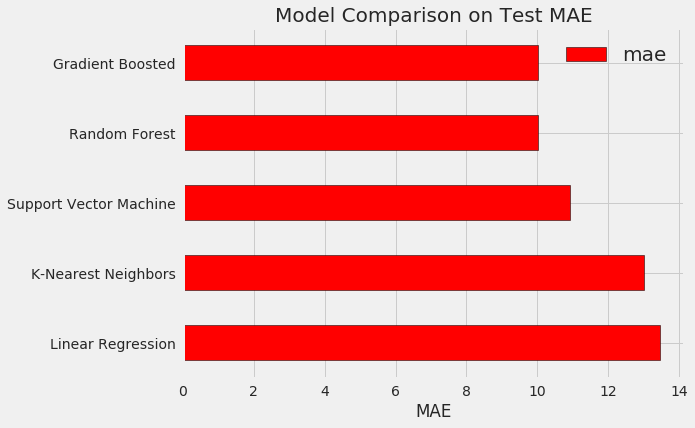

In [28]:
plt.style.use('fivethirtyeight')
figsize(8, 6)
#plt.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['axes.unicode_minus'] = False
# 保存结果
#model_comparison = pd.DataFrame({'model' : ['线性回归', '支持向量机',
#                                           '随机森林', '梯度提升', 'k最近邻'],
#                                'mae' : [lr_mae, svm_mae,
#                                        random_forest_mae, gradient_boosted_mae, knn_mae]})
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# 测试集上MAE的水平条形图
model_comparison.sort_values('mae', ascending=False).plot(x='model', y='mae', kind='barh',
                                                         color='red', edgecolor='black')
# 绘图格式
plt.ylabel('')
plt.yticks(size=14)
plt.xlabel('MAE')
plt.xticks(size=14)
plt.title('Model Comparison on Test MAE', size=20)
# 所有模型都明显优于基线，证明机器学习适用于该项目
# 梯度提升和随机森林表现最佳

# Model Optimization
为特定问题找到**最佳的超参数集**。
## Hyperparameters
* 模型**超参数**是机器学习算法的设置，在训练之前由数据科学家调整。例如，随机森林中的树数量，或者K近邻中使用的邻居数量。

* 模型**参数**是模型在训练期间学习的内容，例如线性回归中的权重。

调整模型超参数可以控制模型中**欠拟合**与**过拟合**的平衡。

通过**更复杂的模型**来校正**欠拟合**，例如在随机森林中使用更多树或在深度神经网络中使用更多层。不合适的模型没有足够的容量（自由度）来学习特征和目标之间的关系，该模型具有**高偏差**。

通过**限制模型的复杂性**和应用**正则化**来尝试纠正**过拟合**。这可能会降低多项式回归的程度，或将随机失活（**dropout**）层添加到深度神经网络。过拟合的模型具有**高方差**并且实际上记住了训练集。

欠拟合和过拟合会导致在测试集上**泛化能力**差。

## Hyperparameter Tuning with Random Search and Cross Validation
* **随机搜索**是指**选择超参数**来评估的方法：定义一系列选项，然后随机选择要尝试的组合。这与网格搜索形成对比，网格搜索评估指定的每个组合。对最佳模型超参数的知识有限时，随机搜索会更好，可以使用随机搜索**缩小选项范围**，然后使用更有限的选项范围进行**网格搜索**。

* **交叉验证**是用于**评估超参数性能**的方法。使用**K-Fold交叉验证**，而不是将训练设置拆分为单独的训练集和验证集，这会减少可以使用的训练数据量。将训练集划分为K个Fold，然后进行迭代过程，首先在Fold的K-1上进行训练，然后评估第k个Fold的性能。重复这个过程K次，所以最终将测试训练数据中的每个例子，关键是每次迭代都在测试没有训练过的数据。在K-Fold交叉验证结束时，将**K次迭代的平均误差**作为最终性能度量，然后立即在所有训练数据上训练模型。然后，记录的性能用于比较超参数的不同组合。

**交叉验证（k=5）:**
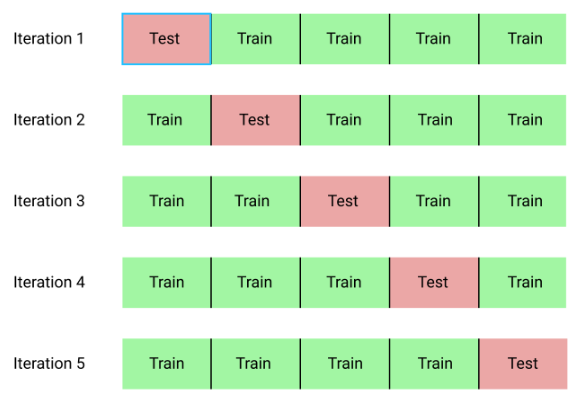

使用交叉验证和随机搜索，选择梯度提升回归的最佳超参数。 首先定义一个网格然后执行迭代过程：从网格中随机抽样一组超参数，使用4-fold交叉验证评估超参数，然后选择具有最佳性能的超参数。

In [18]:
# 优化的损失函数：最小二乘误差，最小绝对误差，Huber损失函数
loss = ['ls', 'lad', 'huber']
# 树的数量
n_estimators = [100, 500, 900, 1100, 1500]
# 树的最大深度
max_depth = [2, 3, 5, 10, 15]
# 叶节点样本的最小数量
min_samples_leaf = [1, 2, 4, 6, 8]
# 用于分割节点的样本的最小数量
min_samples_split = [2, 4, 6, 10]
# 分割时考虑的特征的最大数量
max_features = ['auto', 'sqrt', 'log2', None]
# 定义用于搜索的超参数网格
hyperparameter_grid = {'loss' : loss,
                       'n_estimators' : n_estimators,
                       'max_depth' : max_depth,
                       'min_samples_leaf' : min_samples_leaf,
                       'min_samples_split' : min_samples_split,
                       'max_features' : max_features}

随机化搜索，传递以下参数：
* **estimator**: 模型
* **param_distributions**: 定义参数分布（超参数网格）
* **cv**: k-fold交叉验证的fold数量
* **n_iter**: 尝试不同组合的数量
* **scoring**: 评估候选组合的指标
* **n_jobs**: 并行运行的核心数（-1将使用所有可用的核心）
* **verbose**: 要显示多少信息（1显示有限数量）
* **return_train_score**: 返回每个交叉验证fold的训练分数
* **random_state**: 修复了使用的随机数生成器，因此每次运行都会得到相同的结果

In [19]:
# 创建模型，用于超参数调整
model = GradientBoostingRegressor(random_state = 42)
# 创建随机搜索和4-fold交叉验证
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4,
                               n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1,
                               verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [20]:
# 训练数据
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.9min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

In [21]:
# 获取所有cv结果并按测试性能排序
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,8.858400,0.402171,0.018854,0.000379,500,6,6,None,5,lad,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.859381,-8.773966,-9.325139,-9.036779,-8.998761,0.210901,1,-7.027368,-6.837958,-6.869084,-6.840749,-6.893790,0.078077
3,9.914366,0.350374,0.019439,0.000226,500,6,8,None,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.868788,-8.904791,-9.315304,-9.075321,-9.041004,0.176509,2,-4.482073,-4.326121,-4.823009,-4.229809,-4.465253,0.225313
9,5.355649,0.185076,0.012909,0.000314,500,4,2,auto,3,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.134318,-9.042461,-9.441179,-9.152240,-9.192518,0.149456,3,-7.007604,-7.088986,-6.913108,-6.940327,-6.987506,0.067939
0,1.793021,0.038446,0.005692,0.000208,100,2,6,auto,5,ls,"{'n_estimators': 100, 'min_samples_split': 2, ...",-9.101610,-9.026912,-9.456259,-9.201033,-9.196413,0.162211,4,-7.302003,-7.312645,-7.173397,-7.386171,-7.293554,0.076569
7,4.542243,0.391423,0.016484,0.004280,500,4,6,auto,3,ls,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.146159,-9.199358,-9.699696,-9.357220,-9.350555,0.215966,5,-7.089709,-7.103749,-7.021418,-7.080088,-7.073741,0.031358
10,51.428233,1.503716,0.094706,0.013691,1100,10,6,None,10,huber,"{'n_estimators': 1100, 'min_samples_split': 10...",-9.261256,-9.243867,-9.528538,-9.473096,-9.376652,0.125816,6,-0.378166,-0.459465,-0.393491,-0.370483,-0.400401,0.035092
19,11.436672,0.487051,0.023008,0.000638,1100,6,2,auto,3,lad,"{'n_estimators': 1100, 'min_samples_split': 6,...",-9.379335,-9.382576,-9.473980,-9.290880,-9.381693,0.064740,7,-8.311796,-8.658903,-7.820534,-8.017995,-8.202307,0.316303
2,33.584533,1.101586,0.043828,0.000470,500,4,2,auto,10,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.385744,-9.288317,-9.572674,-9.429825,-9.419115,0.102366,8,-0.164859,-0.193613,-0.164415,-0.141062,-0.165987,0.018629
16,15.728237,0.648144,0.040704,0.006717,1500,4,6,None,3,ls,"{'n_estimators': 1500, 'min_samples_split': 4,...",-9.246573,-9.317156,-9.798950,-9.424668,-9.446787,0.212942,9,-4.821677,-4.876202,-4.776650,-4.729506,-4.801009,0.054284
21,4.027881,0.110574,0.022678,0.003109,500,6,4,log2,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-9.393840,-9.289175,-9.750806,-9.407503,-9.460295,0.173829,10,-5.684121,-5.742441,-5.571781,-5.666476,-5.666205,0.061337


In [22]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

最佳梯度提升模型的超参数值如下:
* loss = lad
* n_estimators = 500
* max_depth = 5
* min_samples_leaf = 6
* min_samples_split = 6
* max_features = None(n_features)

In [24]:
#　使用ｎ_estimators进行网格搜索，研究数木数量对于模型的影响
# 创建一系列用于评估的树的数量
trees_grid = {'n_estimators' : [100, 150, 200, 250, 300, 350, 400, 450,
                                500, 550, 600, 650, 700, 750, 800]}
model = GradientBoostingRegressor(loss = 'lad',
                                 max_depth = 5,
                                 min_samples_leaf = 6,
                                 min_samples_split = 6,
                                 max_features = None,
                                 random_state = 42)
# 应用树木数量进行网格搜索
grid_search = GridSearchCV(estimator = model,
                           param_grid = trees_grid,
                           cv = 4,
                           scoring = 'neg_mean_absolute_error',
                           n_jobs = -1,
                           verbose = 1,
                           return_train_score = True)

In [25]:
# 训练数据
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.1min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

Text(0.5,1,'Performance vs Number of Trees')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


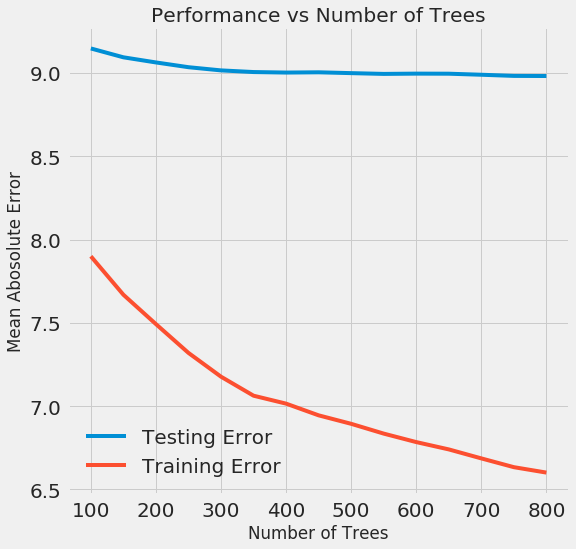

In [29]:
# 保存结果
results = pd.DataFrame(grid_search.cv_results_)
# 性能随树木数量变化
figsize(8, 8)
#plt.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Abosolute Error')
plt.legend()
#plt.title('性能 vs 树木数量')
plt.title('Performance vs Number of Trees')

In [30]:
results.sort_values('mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
14,14.310632,0.360106,0.027986,0.002996,800,{'n_estimators': 800},-8.825018,-8.757257,-9.297520,-9.046451,-8.981504,0.211453,1,-6.739448,-6.648109,-6.486269,-6.530287,-6.601028,0.099437
13,13.665027,0.403314,0.026748,0.000725,750,{'n_estimators': 750},-8.830294,-8.750657,-9.299357,-9.048696,-8.982193,0.213125,2,-6.772908,-6.660453,-6.520818,-6.579989,-6.633542,0.094501
12,13.110428,0.358946,0.027340,0.004541,700,{'n_estimators': 700},-8.835777,-8.754819,-9.313318,-9.052721,-8.989100,0.216536,3,-6.812928,-6.695770,-6.611240,-6.624919,-6.686214,0.079884
9,10.374032,0.181024,0.020440,0.000914,550,{'n_estimators': 550},-8.853451,-8.755897,-9.325442,-9.041991,-8.994138,0.217136,4,-7.003413,-6.781878,-6.809121,-6.745712,-6.835031,0.099783
11,12.041627,0.354594,0.022988,0.000528,650,{'n_estimators': 650},-8.850857,-8.754361,-9.325111,-9.051181,-8.995319,0.218405,5,-6.864375,-6.721452,-6.708191,-6.666758,-6.740194,0.074480


模型**过拟合**：训练误差明显低于测试误差。

* 更多训练数据
* 降低模型复杂度
    + 超参调整
    + 正则化
    + 减少树的数量
    + 减少树的最大深度
    + 增加叶节点的样本最小数量

使用最佳性能模型(n_estimators=800)，接受过拟合。

# Evaluate Final Model on the Test Set
### 最佳模型与默认模型比较

In [32]:
# 默认模型
default_model = GradientBoostingRegressor(random_state = 42)
# 最佳模型
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [48]:
# 五次运行取平均
%timeit -n 1 -r 5 default_model.fit(X, y)

872 ms ± 11.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [49]:
%timeit -n 1 -r 5 final_model.fit(X, y)

13 s ± 82 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [50]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('默认模型在测试集上的性能：MAE = %0.4f' % mae(y_test, default_pred))
print('最佳模型在测试集上的性能：MAE = %0.4f' % mae(y_test, final_pred))

默认模型在测试集上的性能：MAE = 10.0118
最佳模型在测试集上的性能：MAE = 9.0446


最终的模型比基线(默认)模型**性能提高10%**，(在我的计算机上)**运行速度慢了14倍**。

### 预测值和真值分布图

Text(0.5,1,'Test Values and Predictions')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


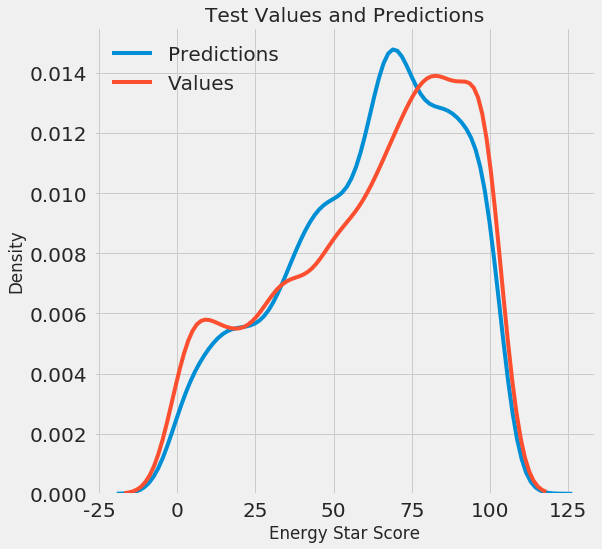

In [51]:
figsize(8, 8)
# 最佳模型的预测值和测试真值的密度图
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')
plt.xlabel('Energy Star Score')
plt.ylabel('Density')
plt.title('Test Values and Predictions')

* 分布几乎相同。
* 预测极值不太准确，更接近中位数。

### 残差直方图(正态分布)

Text(0.5,1,'Distribution of Residuals')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


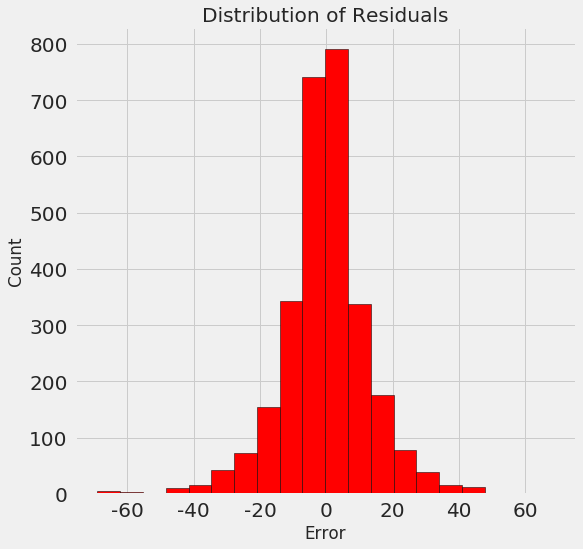

In [56]:
figsize(8, 8)
# 计算残差
residuals = final_pred - y_test
# 绘制残差直方图
plt.hist(residuals, color='red', bins=20, edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Count')
plt.title('Distribution of Residuals')

* 残差接近正态分布
* 低端有一些明显的异常值(预测值远低于真实值的误差)

## Conclusions

* 插补缺失值
* 评估和比较几种机器学习方法
* 使用随机搜索和交叉验证来超参数调整机器学习模型
* 在测试集上评估最佳模型

正确的**特征工程**和收集**更多数据**比微调模型回报更大！